# This sorts the taxi data into zip codes of origin and destination

In [1]:
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from folium.plugins import FastMarkerCluster

In [2]:
#reads in zipcode boundary geojson file
zipcodes = gpd.read_file('data/Chicago/Boundaries - ZIP Codes.geojson') 
print(zipcodes.crs)
zipcodes.head( )

epsg:4326


,objectid,shape_area,shape_len,zip,geometry
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ..."
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ..."
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ..."
3,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ..."
4,37,99039621.2518,47970.1401531,60651,"MULTIPOLYGON (((-87.70656 41.89555, -87.70672 ..."


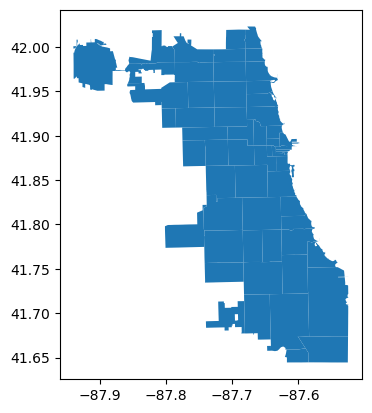

In [3]:
zipcodes.plot();

In [4]:
#drops unneeded zipcode columns
zipcodes = zipcodes[['zip', 'geometry']]

In [5]:
#reads in taxi data
taxis_from = pd.read_csv('data/Chicago/cleaned/taxis_clean_Q1.csv')
print(taxis_from.shape)
taxis_from.head(3)

(1882150, 25)


,Unnamed: 0,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,4,c15aa95b80c88c5f37d8134c70471be379bea040,020ac8feafd80a884d635ff8ffced25759473215d80a58...,03/31/2018 11:45:00 PM,03/31/2018 11:45:00 PM,427.0,2.5,1.703128e+10,1.703108e+10,28.0,...,10.25,Credit Card,Flash Cab,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),29.0
1,5,6e90dac306a89d1e31fc4dd36cbcc133eab32b75,bda723ff7d3238b616907b89512c7279801247b0658190...,03/31/2018 11:45:00 PM,04/01/2018 12:15:00 AM,1205.0,3.0,NaN,NaN,77.0,...,18.00,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),76.0
2,7,40fc22aff29bf3b90d4e6a8a952aa1a7bcf1a490,e02fbefeff55fe8de5aed27b44a1894e437002cb984e6d...,03/31/2018 11:45:00 PM,04/01/2018 12:00:00 AM,668.0,2.8,NaN,NaN,77.0,...,10.25,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),42.001571,-87.695013,POINT (-87.6950125892 42.001571027),76.0


In [6]:
#renames columns
taxis_from = taxis_from.rename(columns={"Pickup Centroid Latitude": "lat", "Pickup Centroid Longitude": "lng"})
taxis_from

,Unnamed: 0,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,...,Trip Total,Payment Type,Company,lat,lng,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,4,c15aa95b80c88c5f37d8134c70471be379bea040,020ac8feafd80a884d635ff8ffced25759473215d80a58...,03/31/2018 11:45:00 PM,03/31/2018 11:45:00 PM,427.0,2.50,1.703128e+10,1.703108e+10,28.0,...,10.25,Credit Card,Flash Cab,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),29.0
1,5,6e90dac306a89d1e31fc4dd36cbcc133eab32b75,bda723ff7d3238b616907b89512c7279801247b0658190...,03/31/2018 11:45:00 PM,04/01/2018 12:15:00 AM,1205.0,3.00,NaN,NaN,77.0,...,18.00,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),76.0
2,7,40fc22aff29bf3b90d4e6a8a952aa1a7bcf1a490,e02fbefeff55fe8de5aed27b44a1894e437002cb984e6d...,03/31/2018 11:45:00 PM,04/01/2018 12:00:00 AM,668.0,2.80,NaN,NaN,77.0,...,10.25,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),42.001571,-87.695013,POINT (-87.6950125892 42.001571027),76.0
3,10,60ba018cd76441d4dc04561007d9eb3c480b51bb,4ba3690e7f7bde263c96de93e97af2af2545f6d16f06b7...,03/31/2018 11:45:00 PM,04/01/2018 12:00:00 AM,974.0,6.10,NaN,NaN,7.0,...,19.25,Cash,Flash Cab,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.850266,-87.667569,POINT (-87.667569312 41.8502663663),68.0
4,12,62e6eb1546abc9063465493f7d342c0e6ba56ee1,68a54d4a1e27d763040f182bb436b3ffb52cf64978b091...,03/31/2018 11:45:00 PM,04/01/2018 12:00:00 AM,990.0,9.60,NaN,NaN,8.0,...,26.00,Cash,Flash Cab,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1882145,5205237,df6543113a2e13cf941994d0b705aa3a12b7cda1,9de14279ac4dc5696c73c13b07b0aaf2b1a1796dda9f4c...,01/01/2018 12:00:00 AM,01/01/2018 12:15:00 AM,780.0,3.40,NaN,NaN,8.0,...,11.75,Cash,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.901207,-87.676356,POINT (-87.6763559892 41.90120699410001),37.0
1882146,5205243,4a0dca45fae35ac8cbb5c9ef774a78f92712dcaf,10ea6a4868a3c8225255617c20b0e0b1f2a56b550efbb9...,01/01/2018 12:00:00 AM,01/01/2018 12:15:00 AM,1320.0,11.10,NaN,NaN,28.0,...,29.00,Cash,Globe Taxi,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.775929,-87.666596,POINT (-87.6665962653 41.7759288274),29.0
1882147,5205244,11f73ea3cdc076716d726af8253d1be9610baf38,31760477ea8a53823f828158e65e02b57866ed72ce86b7...,01/01/2018 12:00:00 AM,01/01/2018 12:00:00 AM,660.0,3.00,NaN,NaN,22.0,...,10.50,Cash,Sun Taxi,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.927261,-87.765502,POINT (-87.7655016086 41.9272609555),23.0
1882148,5205247,18b5ad526d36ee4c527d0ab849a3b5da230bd748,5e8fa091162e91db78f1256e485b80056e45352875fb82...,01/01/2018 12:00:00 AM,01/01/2018 12:15:00 AM,1073.0,4.95,NaN,NaN,NaN,...,21.00,Credit Card,Chicago Carriage Cab Corp,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#creates column containing geopoints
taxis_from['from_geo'] = taxis_from.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)
taxis_from.head(3)

,Unnamed: 0,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,...,Payment Type,Company,lat,lng,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas,from_geo
0,4,c15aa95b80c88c5f37d8134c70471be379bea040,020ac8feafd80a884d635ff8ffced25759473215d80a58...,03/31/2018 11:45:00 PM,03/31/2018 11:45:00 PM,427.0,2.5,1.703128e+10,1.703108e+10,28.0,...,Credit Card,Flash Cab,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),29.0,POINT (-87.64280846600001 41.885300022)
1,5,6e90dac306a89d1e31fc4dd36cbcc133eab32b75,bda723ff7d3238b616907b89512c7279801247b0658190...,03/31/2018 11:45:00 PM,04/01/2018 12:15:00 AM,1205.0,3.0,NaN,NaN,77.0,...,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),76.0,POINT (-87.66341640500001 41.9867118)
2,7,40fc22aff29bf3b90d4e6a8a952aa1a7bcf1a490,e02fbefeff55fe8de5aed27b44a1894e437002cb984e6d...,03/31/2018 11:45:00 PM,04/01/2018 12:00:00 AM,668.0,2.8,NaN,NaN,77.0,...,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),42.001571,-87.695013,POINT (-87.6950125892 42.001571027),76.0,POINT (-87.66341640500001 41.9867118)


In [8]:
#drops unneeded columns
taxis_from_geo = taxis_from[['Trip ID', 'from_geo']]
taxis_from_geo

,Trip ID,from_geo
0,c15aa95b80c88c5f37d8134c70471be379bea040,POINT (-87.64280846600001 41.885300022)
1,6e90dac306a89d1e31fc4dd36cbcc133eab32b75,POINT (-87.66341640500001 41.9867118)
2,40fc22aff29bf3b90d4e6a8a952aa1a7bcf1a490,POINT (-87.66341640500001 41.9867118)
3,60ba018cd76441d4dc04561007d9eb3c480b51bb,POINT (-87.649488729 41.922686284)
4,62e6eb1546abc9063465493f7d342c0e6ba56ee1,POINT (-87.63330803700001 41.899602111)
...,...,...
1882145,df6543113a2e13cf941994d0b705aa3a12b7cda1,POINT (-87.63330803700001 41.899602111)
1882146,4a0dca45fae35ac8cbb5c9ef774a78f92712dcaf,POINT (-87.66351754999999 41.874005383)
1882147,11f73ea3cdc076716d726af8253d1be9610baf38,POINT (-87.699155343 41.92276062)
1882148,18b5ad526d36ee4c527d0ab849a3b5da230bd748,POINT (nan nan)


In [9]:
#creates geodataframe from taxi info
taxis_from_geo = gpd.GeoDataFrame(taxis_from_geo, 
                           crs = zipcodes.crs, 
                           geometry = taxis_from['from_geo'])

In [10]:
#sorts origin taxi info into zipcodes
from_by_zip = gpd.sjoin(taxis_from_geo, zipcodes, op = 'within')
from_by_zip = from_by_zip.rename(columns={"Trip ID": "trip_id", 'geometry': 'zip_geo', "zip": "from_zip"})
from_by_zip.head()

,trip_id,from_geo,zip_geo,index_right,from_zip
0,c15aa95b80c88c5f37d8134c70471be379bea040,POINT (-87.64280846600001 41.885300022),POINT (-87.64281 41.88530),44,60661
40,399d2f43c6234aa6c1dd62fada56d4e8a43d1e61,POINT (-87.64280846600001 41.885300022),POINT (-87.64281 41.88530),44,60661
137,48f3db9a578226cf25d3fe299c2b82584d0dec2e,POINT (-87.642648998 41.879255084),POINT (-87.64265 41.87926),44,60661
218,15a43751c5a536a85614c9e6a6dbc8ccaf196cac,POINT (-87.642648998 41.879255084),POINT (-87.64265 41.87926),44,60661
449,98ee5866650811f288a2de2140088e70f9d441b7,POINT (-87.642648998 41.879255084),POINT (-87.64265 41.87926),44,60661


In [11]:
from_by_zip.from_zip.value_counts()

60666    321251
60610    183791
60611    147252
60604    140410
60603    110065
60616     85983
60638     77886
60607     76888
60657     73811
60614     62920
60661     59999
60601     59394
60654     59110
60622     31465
60640     24720
60618     20414
60660     17333
60625     15155
60647     13802
60612     13223
60637     12162
60605     11037
60645      9301
60626      9160
60642      7764
60613      6420
60630      5168
60641      3437
60608      3161
60615      2908
60619      2543
60651      2431
60631      2395
60639      2389
60653      2196
60659      1922
60623      1810
60649      1620
60644      1473
60609      1245
60628      1177
60643      1035
60617      1012
60646       993
60634       902
60629       871
60632       843
60621       644
60620       614
60652       440
60624       347
60636       343
60707       248
60655        66
60633        50
60656         5
Name: from_zip, dtype: int64

### The following repeats the same process for destination data

In [12]:
taxis_to = pd.read_csv('data/Chicago/cleaned/taxis_clean_Q1.csv')
print(taxis_to.shape)
taxis_to.head(3)

(1882150, 25)


,Unnamed: 0,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
0,4,c15aa95b80c88c5f37d8134c70471be379bea040,020ac8feafd80a884d635ff8ffced25759473215d80a58...,03/31/2018 11:45:00 PM,03/31/2018 11:45:00 PM,427.0,2.5,1.703128e+10,1.703108e+10,28.0,...,10.25,Credit Card,Flash Cab,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),29.0
1,5,6e90dac306a89d1e31fc4dd36cbcc133eab32b75,bda723ff7d3238b616907b89512c7279801247b0658190...,03/31/2018 11:45:00 PM,04/01/2018 12:15:00 AM,1205.0,3.0,NaN,NaN,77.0,...,18.00,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),76.0
2,7,40fc22aff29bf3b90d4e6a8a952aa1a7bcf1a490,e02fbefeff55fe8de5aed27b44a1894e437002cb984e6d...,03/31/2018 11:45:00 PM,04/01/2018 12:00:00 AM,668.0,2.8,NaN,NaN,77.0,...,10.25,Credit Card,Flash Cab,41.986712,-87.663416,POINT (-87.6634164054 41.9867117999),42.001571,-87.695013,POINT (-87.6950125892 42.001571027),76.0


In [13]:
taxis_to = taxis_to.rename(columns={"Dropoff Centroid Latitude": "lat", "Dropoff Centroid Longitude": "lng"})

In [14]:
taxis_to['to_geo'] = taxis_to.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))), 
                                        axis=1)

In [15]:
taxis_to_geo = taxis_to[['Trip ID', 'to_geo']]

In [16]:
taxis_to_geo = gpd.GeoDataFrame(taxis_to_geo, 
                           crs = zipcodes.crs, 
                           geometry = taxis_to['to_geo'])

In [17]:
to_by_zip = gpd.sjoin(taxis_to_geo, zipcodes, op = 'within')
to_by_zip = to_by_zip.rename(columns={"Trip ID": "trip_id", 'geometry': 'zip_geo', "zip": "to_zip"})
to_by_zip.head()

,trip_id,to_geo,zip_geo,index_right,to_zip
0,c15aa95b80c88c5f37d8134c70471be379bea040,POINT (-87.618868355 41.890922026),POINT (-87.61887 41.89092),5,60611
6,89c636b7526952c8302912814a43172070798df8,POINT (-87.618868355 41.890922026),POINT (-87.61887 41.89092),5,60611
37,c8047dc2b22cd529d85aca53ec5dd5af0268e1b0,POINT (-87.619710672 41.89503345),POINT (-87.61971 41.89503),5,60611
38,0d525e081e0dc38fd56b0d49682f4ac442b2ee38,POINT (-87.626210532 41.899155613),POINT (-87.62621 41.89916),5,60611
61,03b3ea5d521eabe84bbee9e7b088865e8f83d5e7,POINT (-87.618868355 41.890922026),POINT (-87.61887 41.89092),5,60611


### Next, the origin and destination datasets will be merged and filtered for trips between different zip codes

In [18]:
trips_by_zip = from_by_zip.merge(to_by_zip, left_on='trip_id', right_on='trip_id')

In [19]:
trips_by_zip = trips_by_zip[['trip_id', 'from_zip', 'to_zip']]
trips_by_zip

,trip_id,from_zip,to_zip
0,c15aa95b80c88c5f37d8134c70471be379bea040,60661,60611
1,399d2f43c6234aa6c1dd62fada56d4e8a43d1e61,60661,60610
2,48f3db9a578226cf25d3fe299c2b82584d0dec2e,60661,60610
3,15a43751c5a536a85614c9e6a6dbc8ccaf196cac,60661,60654
4,98ee5866650811f288a2de2140088e70f9d441b7,60661,60654
...,...,...,...
1582432,f3bfd8043640a5a1a9e81bff1808c75acc981ddf,60655,60643
1582433,2877dafc6a8f87907ef145b36ce4fbc5b87e4182,60656,60666
1582434,80b29c9a7e34c13174814e1119583a2e5e0bdb2f,60656,60610
1582435,3add11d9affe585b75c17aaba00da226eba0389c,60656,60611


In [20]:
#displays how many trips stay in the same zipcode
trips_by_zip.loc[trips_by_zip.from_zip == trips_by_zip.to_zip] 

,trip_id,from_zip,to_zip
37,710bde71e429e0c5ad6617ca5a243948b48f6ea9,60661,60661
48,2c060a216f68155584105eb0e15c7014dc48808f,60661,60661
147,2c6f98a8672bb82df8864df5ef0f3f77bb16af56,60661,60661
238,e7516ba74add82c4cd6ffb02330b351569128c05,60661,60661
646,d5aeadd90203509ab1feeb557ca8d941b74a6cdc,60661,60661
...,...,...,...
1582272,6904ad1caa4506e707a928f4ab51e4fb9b287a1d,60636,60636
1582331,e574554a02a69580b1510069aa78f327e130077e,60636,60636
1582336,1d2a072e614882a2d2cad5320b0b017cf5123976,60636,60636
1582365,da5823d062ca04af1beae0c6da4a6b26b3bcad42,60633,60633


In [21]:
#save the trips that are between zip codes
diff = trips_by_zip.loc[trips_by_zip.from_zip != trips_by_zip.to_zip] 

In [22]:
#counts the number of trips between each pair of zip codes
diff[['from_zip', 'to_zip']].value_counts().reset_index(name='count')

,from_zip,to_zip,count
0,60666,60611,43976
1,60610,60657,30695
2,60611,60616,25708
3,60611,60666,25622
4,60666,60603,23319
...,...,...,...
2363,60620,60660,1
2364,60621,60625,1
2365,60621,60631,1
2366,60621,60647,1
